<h2>Transfer Learning with Convolutional Neural Networks For Classification with PyTorch and Computer Vision Learning 
Studio
 (CV Studio)</a></h2>
<h4>Project: Head Orientation Classification</h4>
<h4>Training Run: Transfer Learning for Head Orientation Classification</h4>


Train a deep neural network for image classification using transfer learning (using pre trained CNN to classify).

In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest. 
We are using a pretrained Convolutional Network as a feature generator and using this Network to train the output layer. 


As CNNs got deeper (more layers and more parameters) the vanishing gradient began to become a problem.
ResNet help solve the problem by introducing Residual learning:
Residual layers or skip connections allows the gradient to bypass different layers improving performance
we can now build much deeper Networks.

We will use ResNet18 as the pretrained model 'import torchvision.models.resnet18'
More info: https://pytorch.org/vision/main/generated/torchvision.models.resnet18.html#torchvision.models.resnet18



<img src="scratchmodel.png" width="400" />
<img src="pretrainedmodel.png" width="400" />

## Import Libraries and Helpful Functions


In [ ]:
# Libraries for OS and Cloud:
import os
import uuid
import shutil
import json
from botocore.client import Config
import ibm_boto3
import copy
from datetime import datetime
from skillsnetwork import cvstudio 
# Libraries for Data Processing and Visualization:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from matplotlib.pyplot import imshow
from tqdm import tqdm
from ipywidgets import IntProgress
import time 
# Deep Learning Libraries:
import torch
import torchvision.models as models #We will use resnet18 as a preliminary pretrained model
from torch.utils.data import Dataset, DataLoader,random_split
from torch.optim import lr_scheduler
from torchvision import transforms
import torch.nn as nn
torch.manual_seed(0)

Define our device as the first visible cuda device if we have CUDA available:


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("the device type is", device)

the device type is cpu


## Load Data


Preprocess dataset by changing the shape of the image, converting to tensor and normalizing the image channels. Also, perform data augmentation on the training dataset. 


<code>
<p>composed = transforms.Compose([transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),transforms.RandomRotation(degrees=5)
                               , transforms.ToTensor()
                               , transforms.Normalize(mean, std)])</p>
    </code>


Download the data:  (these are the images that CV Studio made from the frames of the videos we feed into it and it comes with the annotations we gave each image)


In [10]:
cvstudioClient = cvstudio.CVStudio()
cvstudioClient.downloadAll() 

100%|██████████| 250/250 [00:32<00:00,  7.60it/s]


Get training and validation dataset. For now, using 70% of the data for training.


In [11]:
percentage_train=0.7
train_set=cvstudioClient.getDataset(train_test='train',percentage_train=percentage_train)
val_set=cvstudioClient.getDataset(train_test='test',percentage_train=percentage_train)

defult transform for pretrained model resnet18
this is the training set
defult transform for pretrained model resnet18
this is the test set


Plot some of our dataset to make sure it loaded and transformed the images correctly


In [7]:
# Plot the transformed image:
def imshow_(inp, title=None):
    """Imshow for Tensor."""
    inp = inp .permute(1, 2, 0).numpy() 
    print(inp.shape)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  
    plt.show()

(224, 224, 3)


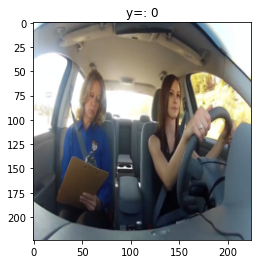

(224, 224, 3)


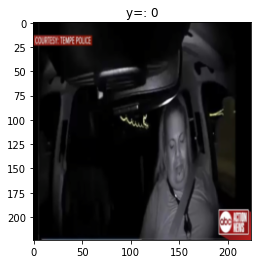

(224, 224, 3)


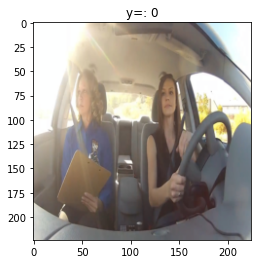

In [12]:
i=0

for x,y  in val_set:
    imshow_(x,"y=: {}".format(str(y.item())))
    i+=1
    if i==3: # to just show a couple, in reality val_set consits of all 30% of the dataset
        break

## Hyperparameters


In [ ]:
# Epoch indicates the number of passes of the entire training dataset
n_epochs=11
# Batch size is the number of training samples utilized in one iteration
batch_size=32
# Learning rate is used in the training of neural networks.Between 0.0 and 1.0.
lr=0.000001
# Momentum is a term used in the gradient descent algorithm to improve training results:
momentum=0.9

If you set to <code>lr_scheduler=True</code>  for every epoch use a learning rate scheduler changes the range of the learning rate from a maximum or minimum value. The learning rate usually decays over time.


In [17]:
lr_scheduler=True
base_lr=0.001
max_lr=0.01

# Load Model and Train


In [18]:
def train_model(model, train_loader,validation_loader, criterion, optimizer, n_epochs,print_=True):
    loss_list = []
    accuracy_list = []
    correct = 0
    #global:val_set
    n_test = len(val_set)
    accuracy_best=0
    best_model_wts = copy.deepcopy(model.state_dict())

    # Loop through epochs
    print("The first epoch should take several minutes")
    for epoch in tqdm(range(n_epochs)):
        
        loss_sublist = []
        # Loop through the data in loader

        for x, y in train_loader:
            x, y=x.to(device), y.to(device)
            model.train() 

            z = model(x)
            loss = criterion(z, y)
            loss_sublist.append(loss.data.item())
            loss.backward()
            optimizer.step()

            optimizer.zero_grad()
        print("epoch {} done".format(epoch) )

        scheduler.step()    
        loss_list.append(np.mean(loss_sublist))
        correct = 0


        for x_test, y_test in validation_loader:
            x_test, y_test=x_test.to(device), y_test.to(device)
            model.eval()
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / n_test
        accuracy_list.append(accuracy)
        if accuracy>accuracy_best:
            accuracy_best=accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
        
        
        if print_:
            print('learning rate',optimizer.param_groups[0]['lr'])
            print("The validaion  Cost for each epoch " + str(epoch + 1) + ": " + str(np.mean(loss_sublist)))
            print("The validation accuracy for epoch " + str(epoch + 1) + ": " + str(accuracy)) 
    model.load_state_dict(best_model_wts)    
    return accuracy_list,loss_list, model

 Load the pre-trained model resnet18. Set the parameter pretrained to true.


In [19]:
model = models.resnet18(pretrained=True)

We will only train the last layer of the network set the parameter <code>requires_grad</code> to <code>False</code>, the network is a fixed feature extractor.


In [20]:
 for param in model.parameters():
        param.requires_grad = False
    

Number of classes


In [21]:
n_classes=train_set.n_classes
n_classes

2

Replace the output layer model.fc of the neural network with a nn.Linear object, to classify <code>n_classes</code> different classes. For the parameters in_features  remember the last hidden layer has 512 neurons.


In [22]:
# Type your code here
model.fc = nn.Linear(512, n_classes)

Set device type


In [23]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Cross-entropy loss, or log loss, measures the performance of a classification model combines LogSoftmax in one object class. It is useful when training a classification problem with C classes.


In [24]:
criterion = nn.CrossEntropyLoss()

Create a training loader and validation loader object.


In [25]:
train_loader = torch.utils.data.DataLoader(dataset=train_set , batch_size=batch_size,shuffle=True)
validation_loader= torch.utils.data.DataLoader(dataset=val_set , batch_size=1)

Use the optim package to define an Optimizer that will update the weights of the model for us. 


In [26]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)


We use <a href='https://arxiv.org/pdf/1506.01186.pdf?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-cvstudio-2021-01-01'>Cyclical Learning Rates</a>


In [27]:
if lr_scheduler:
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.01,step_size_up=5,mode="triangular2")

In [28]:
start_datetime = datetime.now()
start_time=time.time()

accuracy_list,loss_list, model=train_model(model,train_loader , validation_loader, criterion, optimizer, n_epochs=n_epochs)

end_datetime = datetime.now()
current_time = time.time()
elapsed_time = current_time - start_time
print("elapsed time", elapsed_time )

  0%|          | 0/11 [00:00<?, ?it/s]

The first epoch should take several minutes
epoch 0 done


  9%|▉         | 1/11 [01:21<13:32, 81.23s/it]

learning rate 0.002800000000000002
The validaion  Cost for each epoch 1: 0.7306890413165092
The validation accuracy for epoch 1: 0.48
epoch 1 done


 18%|█▊        | 2/11 [02:40<12:02, 80.28s/it]

learning rate 0.0046
The validaion  Cost for each epoch 2: 0.966372087597847
The validation accuracy for epoch 2: 0.72
epoch 2 done


 27%|██▋       | 3/11 [04:01<10:43, 80.48s/it]

learning rate 0.006400000000000001
The validaion  Cost for each epoch 3: 1.3191595934331417
The validation accuracy for epoch 3: 0.72
epoch 3 done


 36%|███▋      | 4/11 [05:28<09:41, 83.04s/it]

learning rate 0.008199999999999999
The validaion  Cost for each epoch 4: 1.5838077664375305
The validation accuracy for epoch 4: 0.56
epoch 4 done


 45%|████▌     | 5/11 [06:50<08:15, 82.53s/it]

learning rate 0.010000000000000002
The validaion  Cost for each epoch 5: 1.5042510856874287
The validation accuracy for epoch 5: 0.76
epoch 5 done


 55%|█████▍    | 6/11 [08:08<06:44, 80.97s/it]

learning rate 0.008199999999999999
The validaion  Cost for each epoch 6: 0.8165781460702419
The validation accuracy for epoch 6: 0.68
epoch 6 done


 64%|██████▎   | 7/11 [09:29<05:24, 81.05s/it]

learning rate 0.006400000000000001
The validaion  Cost for each epoch 7: 0.5105540603399277
The validation accuracy for epoch 7: 0.56
epoch 7 done


 73%|███████▎  | 8/11 [10:56<04:08, 82.86s/it]

learning rate 0.0046
The validaion  Cost for each epoch 8: 1.0120991915464401
The validation accuracy for epoch 8: 0.64
epoch 8 done


 82%|████████▏ | 9/11 [12:20<02:46, 83.38s/it]

learning rate 0.002800000000000002
The validaion  Cost for each epoch 9: 1.2120348736643791
The validation accuracy for epoch 9: 0.76
epoch 9 done


 91%|█████████ | 10/11 [13:39<01:22, 82.02s/it]

learning rate 0.001
The validaion  Cost for each epoch 10: 0.637499175965786
The validation accuracy for epoch 10: 0.64
epoch 10 done


100%|██████████| 11/11 [15:07<00:00, 82.49s/it]

learning rate 0.001900000000000001
The validaion  Cost for each epoch 11: 0.7978793233633041
The validation accuracy for epoch 11: 0.72


elapsed time 907.7028572559357


Report the results of the training run back to CV Studio


In [31]:
parameters = {
    'epochs': n_epochs,
    'learningRate': lr,
    'momentum':momentum,
    'percentage used training':percentage_train,
    "learningRatescheduler": {"lr_scheduler":lr_scheduler,"base_lr":base_lr, "max_lr" :max_lr}
    
    
}
result = cvstudioClient.report(started=start_datetime, completed=end_datetime, parameters=parameters, accuracy={ 'accuracy': accuracy_list, 'loss': loss_list })

if result.ok:
    print('Congratulations your results have been reported back to CV Studio!')

Congratulations your results have been reported back to CV Studio!


Save the model to model.pt


In [32]:
# Save the model to model.pt
torch.save(model.state_dict(), 'model.pt')

# Save the model and report back to CV Studio
result = cvstudioClient.uploadModel('model.pt', {'numClasses': n_classes})

File Uploaded


Plot train cost and validation accuracy


In [6]:
def plot_COST_ACC(COST,ACC):    
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color = color)
    ax1.set_xlabel('Iteration', color = color)
    ax1.set_ylabel('total loss', color = color)
    ax1.tick_params(axis = 'y', color = color)
    
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color = color)  # we already handled the x-label with ax1
    ax2.plot(ACC, color = color)
    ax2.tick_params(axis = 'y', color = color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    plt.show()

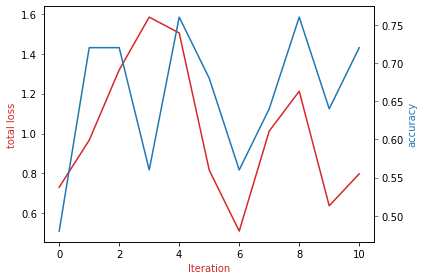

In [33]:
plot_COST_ACC(loss_list,accuracy_list)

Load the model that performs best:  


In [34]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, n_classes)
model.load_state_dict(torch.load( "model.pt"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
# Compare the prediction and actual value:

def result(model,x,y):
    #x,y=sample
    z=model(x.unsqueeze_(0))
    _,yhat=torch.max(z.data, 1)
    
    if yhat.item()!=y:
        text="predicted: {} actual: {}".format(str(yhat.item()),y)
        print(text)